In [5]:
!pip install matplotlib
import matplotlib
import matplotlib.pyplot as plt                 # This will import plotting module
import numpy as np
import PIL
from PIL import Image, ImageFile
!pip install opencv-python
import cv2



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\tahol\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\tahol\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [27]:
def readfile(file, downsample_factor):

    image_bgr = cv2.imread(file)
    
    #If necessary for performance speed, compress the file
    new_size = (int(image_bgr.shape[0]*downsample_factor),int(image_bgr.shape[1]*downsample_factor))
    image_resized = cv2.resize(image_bgr,new_size,interpolation =cv2.INTER_AREA)

    #For the chosen segmentation method it has been decided to segment the image
    #using the hue channel of a converted hsv image to distinguish between land and sea.

    image_hsv = cv2.cvtColor(image_resized, cv2.COLOR_BGR2HSV)
    
    return image_hsv


def otsu_segmentation(image_hsv):
    
    hue_channel = image_hsv[: , : , 0]

    # bins_num = 256
    # hist, bin_edges = np.histogram(hue_channel, bins = bins_num)
    # bin_mids = (bin_edges[:-1] + bin_edges[1:])/2

    # weight1 = np.cumsum(hist)
    # weight2 = np.cumsum(hist[::-1])[::-1]

    # # Get the class means mu0(t)
    # mean1 = np.cumsum(hist * bin_mids) / weight1
    # # Get the class means mu1(t)
    # mean2 = (np.cumsum((hist * bin_mids)[::-1]) / weight2[::-1])[::-1]
    
    # inter_class_variance = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2
    
    # # Maximize the inter_class_variance function val
    # index_of_max_val = np.argmax(inter_class_variance)
    
    # threshold = bin_mids[:-1][index_of_max_val]

    otsu_threshold, image_result = cv2.threshold(
    hue_channel, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU,)

    return image_result, otsu_threshold

def sort_key(point):
    return point[1] * 100 + point[0]

def point_array(image_result):
    black = []
    white = []

    x = image_result.shape[0]-1
    y = image_result.shape[1]-1

    for i in range(x+1):
        for j in range(y+1):
            if image_result[i][j]==1:
                black.append([j,x-i])
            else:
                white.append([j,x-i])

    black = np.array(black)*2 + 1
    white = np.array(white)*2 + 1

    xblack = [point[0] for point in black]
    yblack = [point[1] for point in black]

    xwhite = [point[0] for point in white]
    ywhite = [point[1] for point in white]

    state = {tuple(point): True for point in black}
    state.update({tuple(point): False for point in white})
    sorted_dict = sorted(state.items(), key=lambda x: sort_key(x[0]))
    state_dict = dict(sorted_dict)

    return state_dict, xblack, yblack, xwhite, ywhite

def get_value(i,j,state_dict):
    A = int(state_dict[(i    , j    )])
    B = int(state_dict[(i + 2, j    )])
    C = int(state_dict[(i    , j + 2)])
    D = int(state_dict[(i + 2, j + 2)])
    return A + B*2 + C*4 + D*8

def number_subgrids(state_dict, xblack, yblack, xwhite, ywhite):
    values = {}

    x_len = max(xblack+xwhite)
    y_len = max(yblack+ywhite)

    for j in range(1,y_len,2):
        for i in range(1,x_len,2):
            values.update({(i+1,j+1) : get_value(i,j,state_dict)})
    
    return values,x_len,y_len

# def Segment(start,end):
#     plt.plot([start[0],end[0]],[start[1],end[1]],color = "blue")
#     return start,end

def generate_edges(i,j,index):
    x,y = i,j 
    vector = []
    if index == 0 or index == 15:
        return 
    elif index == 1 or index == 14:
        start = (x+1,y)
        end = (x,y+1)
        vector.append((start,end))
    elif index == 2 or index == 13:
        start = (x+1,y)
        end = (x+2,y+1)
        vector.append((start,end))
    elif index == 3 or index == 12:
        start = (x,y+1)
        end = (x+2,y+1)
        vector.append((start,end))
    elif index == 7 or index == 8:
        start = (x+2,y+1)
        end = (x+1,y+2)
        vector.append((start,end))
    elif index == 9:
        start = (x,y+1)
        end = (x+1,y+2)
        vector.append((start,end))
        start = (x+1,y)
        end = (x+2,y+1)
        vector.append((start,end))
    elif index == 5 or index == 10:
        start = (x+1,y)
        end = (x+1,y+2)
        vector.append((start,end))
    elif index == 4 or index == 11:
        start = (x,y+1)
        end = (x+1,y+2)
        vector.append((start,end))
    elif index == 6:
        start = (x+2,y+1)
        end = (x+1,y+2)
        vector.append((start,end))
        start = (x+1,y)
        end = (x,y+1)
        vector.append((start,end))
        
    return vector

def list_vectors(x_len,y_len,state_dict):

    vectors = []

    for j in range(1,y_len,2):

        for i in range(1,x_len,2):

            index = get_value(i,j,state_dict)
            
            if index == 6 or index == 9:

                double_vec = generate_edges(i,j,index)
                vectors.append([double_vec[0]])
                vectors.append([double_vec[1]])

            else:

                vectors.append(generate_edges(i,j,index))

    vectors = [x for x in vectors if x is not None] #filtering None values
    
    return vectors

def vector_shapes(vectors):
    # Initialize empty list to store shapes
    shapes = []

    # Initialize set to keep track of indices of vectors that need to be removed
    indices_to_remove = set(range(len(vectors)))

    # Iterate until there are no more vectors to process
    while indices_to_remove:
        # Initialize a new shape
        shape = []
        
        # Get the first vector and extract the tuple of points
        vector = vectors[indices_to_remove.pop()][0]  # Get the tuple from the list
        start_point, end_point = vector  # Unpack the tuple

        # Add the start and end points to the shape
        shape.extend([start_point, end_point])

        # Flag to check if a match is found
        matched = True
        
        # Continue until no more matches are found
        while matched:
            # Reset match flag
            matched = False
            # Iterate through indices of vectors to remove
            for idx in list(indices_to_remove):
                # Get the vector at the current index and extract the tuple of points
                vec = vectors[idx][0]  # Extract the tuple

                # Check if the vector connects to the shape
                if vec[0] == end_point:
                    # Append the matching vector's end point
                    end_point = vec[1]
                    shape.append(end_point)
                    indices_to_remove.remove(idx)
                    matched = True
                    break
                elif vec[1] == end_point:
                    # Append the matching vector's start point (reverse match)
                    end_point = vec[0]
                    shape.append(end_point)
                    indices_to_remove.remove(idx)
                    matched = True
                    break
                elif vec[0] == start_point:
                    # If the start of the shape matches a vector, prepend it
                    start_point = vec[1]
                    shape.insert(0, start_point)  # Add to the beginning of the shape
                    indices_to_remove.remove(idx)
                    matched = True
                    break
                elif vec[1] == start_point:
                    # If the start of the shape matches a reversed vector, prepend it
                    start_point = vec[0]
                    shape.insert(0, start_point)
                    indices_to_remove.remove(idx)
                    matched = True
                    break

        # Add the completed shape to the list of shapes
        shapes.append(shape)
    
    shapes = sorted(shapes, key = lambda shape: len(shape), reverse = True)
    
    return shapes

def show_coastline(shapes,image_hsv,x_len, y_len):

    plt.figure(figsize = (10,5))
    plt.subplot(1,2,1)
    plt.title("Coastline Vector Extracted")
    for i in range(1):
        coastline_vector = shapes[i]
        xcoords = []
        ycoords = []
        for point in coastline_vector:
            xcoords.append(point[0])
            ycoords.append(point[1])
        plt.plot(xcoords,ycoords,linewidth = 1)    
    plt.xlim((0,x_len))
    plt.ylim((0,y_len))
    

    plt.subplot(1,2,2)
    plt.title('Original Image')
    plt.imshow(cv2.cvtColor(image_hsv, cv2.COLOR_HSV2RGB))
    plt.axis('off')
   
    plt.show()
    return shapes[0]


In [28]:
def main(file,downsample_factor):
    image = readfile(file,downsample_factor)
    result_image, threshold = otsu_segmentation(image)
    state_dict, xblack, yblack, xwhite, ywhite = point_array(result_image)
    values,x_len,y_len = number_subgrids(state_dict, xblack, yblack, xwhite, ywhite)
    vectors = list_vectors(x_len,y_len,state_dict)
    shapes = vector_shapes(vectors)
    coastline_vector = show_coastline(shapes,image,x_len, y_len)
    return coastline_vector

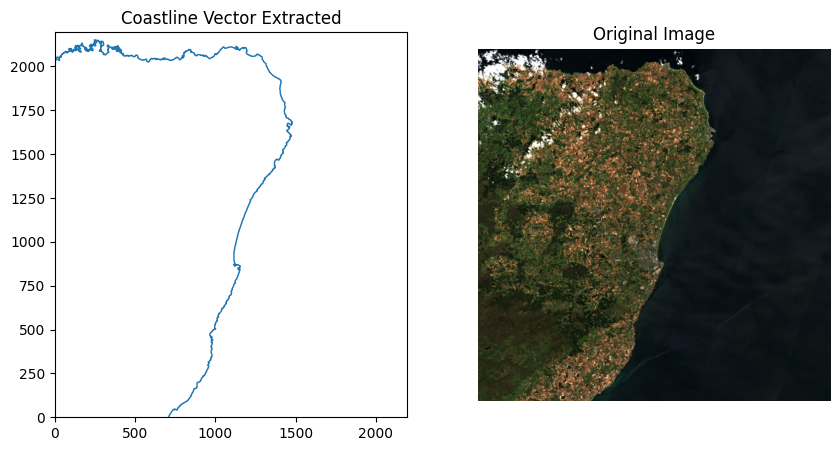

In [31]:
file = "Aberdeenshire.tif"
downsample_factor = 0.1
coastline = main(file,downsample_factor)